<a href="https://colab.research.google.com/github/wangechi01-a/AirQo-African-Air-Quality/blob/main/Fraud_Detection_in_Electricity_and_Gas_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
!pip install xgboost

In [4]:
pip install optuna

# Import the necessary libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
import gc

from scipy import stats

from scipy.stats import boxcox,zscore
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Load the Datasets

In [6]:
client_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection Zindi/client_train.csv")
invoice_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection Zindi/invoice_train.csv")

client_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection Zindi/client_test.csv")
invoice_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection Zindi/invoice_test.csv")

ss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection Zindi/SampleSubmission (3).csv")

In [7]:
# Check the top rows of the dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [8]:
# Check the top rows of the dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [9]:
# Check the top rows of the dataset
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [10]:
# Check the top rows of the dataset
invoice_test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [11]:
#check the shape of the dataset
client_train.shape,invoice_train.shape,client_test.shape,invoice_test.shape

((135493, 6), (4476749, 16), (58069, 5), (1939730, 16))

In [12]:
# check more information of the dataset; datatypes,null-count and the columns
client_train.info(), client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


(None, None)

In [13]:
invoice_train.info(), invoice_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1939730 entries, 0 to 1939729
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   in

(None, None)

In [14]:
#Check for missing values
client_train.isnull().sum(), client_test.isnull().sum()

(disrict          0
 client_id        0
 client_catg      0
 region           0
 creation_date    0
 target           0
 dtype: int64,
 disrict          0
 client_id        0
 client_catg      0
 region           0
 creation_date    0
 dtype: int64)

- There are no missing values in the client train and client test

In [15]:
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

There are no missing values

In [16]:
invoice_test.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

There are no missing values

In [17]:
client_train.describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,135493.0,63.511222,3.354400,60.0,62.0,62.0,69.0,69.0
client_catg,135493.0,11.512506,4.423761,11.0,11.0,11.0,11.0,51.0
region,135493.0,206.159809,104.207044,101.0,103.0,107.0,307.0,399.0
target,135493.0,0.055841,0.229614,0.0,0.0,0.0,0.0,1.0


In [18]:
client_train.describe(include = 'object').T

,count,unique,top,freq
client_id,135493,135493,train_Client_0,1
creation_date,135493,8088,20/11/1997,214


In [19]:
 invoice_train.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


# Visualization

In [20]:
# check unique values in dataset
client_train.apply(lambda x: len(x.unique()))

disrict               4
client_id        135493
client_catg           3
region               25
creation_date      8088
target                2
dtype: int64

In [21]:
invoice_train.apply(lambda x: len(x.unique()))

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

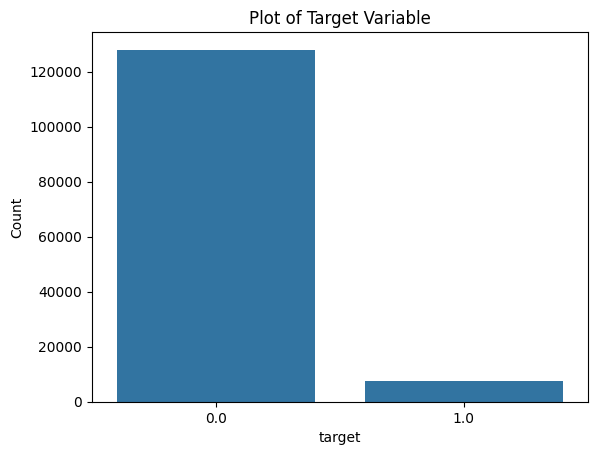

In [22]:
# Explore Target distribution
sns.countplot(x='target', data=client_train)
plt.title('Plot of Target Variable')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

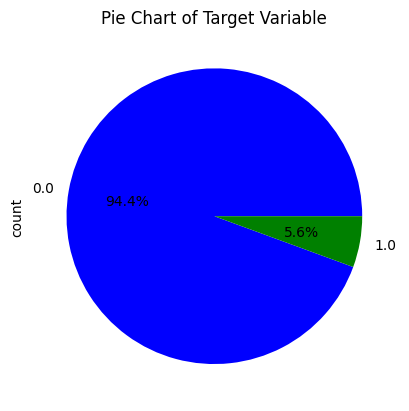

In [23]:
client_train['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green'])
plt.title('Pie Chart of Target Variable')
plt.show()

The chart shows that there are 94.4% of Legitimates and 5.6% of fradulents.

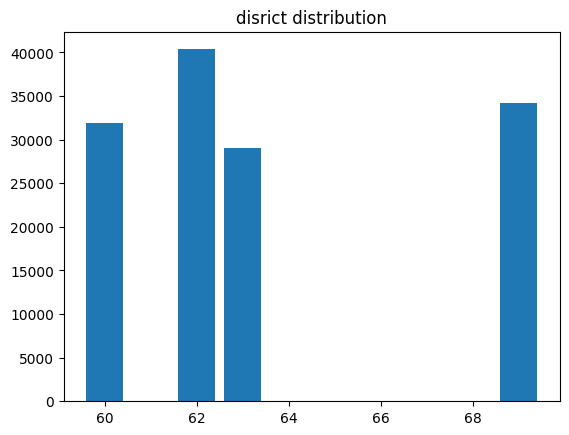

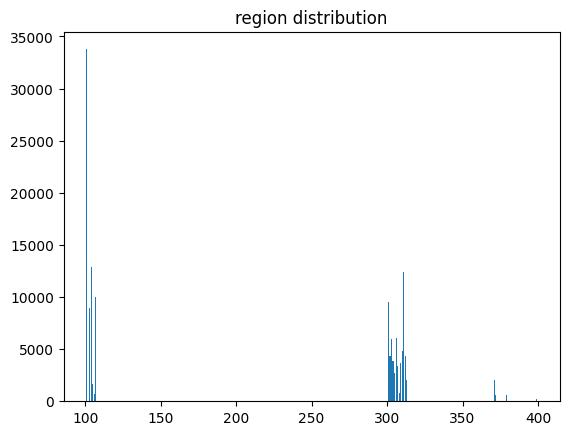

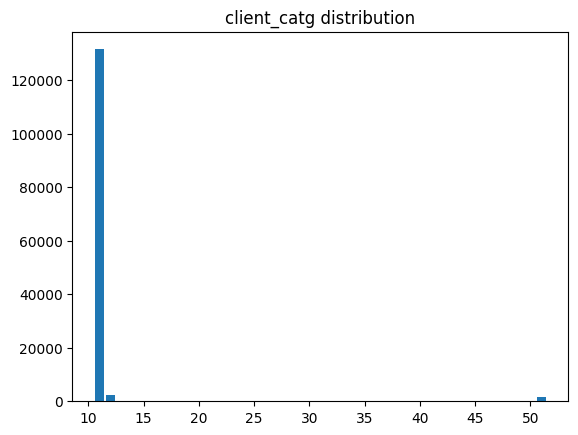

In [24]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

disrict
62    40353
69    34231
60    31922
63    28987
Name: count, dtype: int64


<Figure size 1100x500 with 0 Axes>

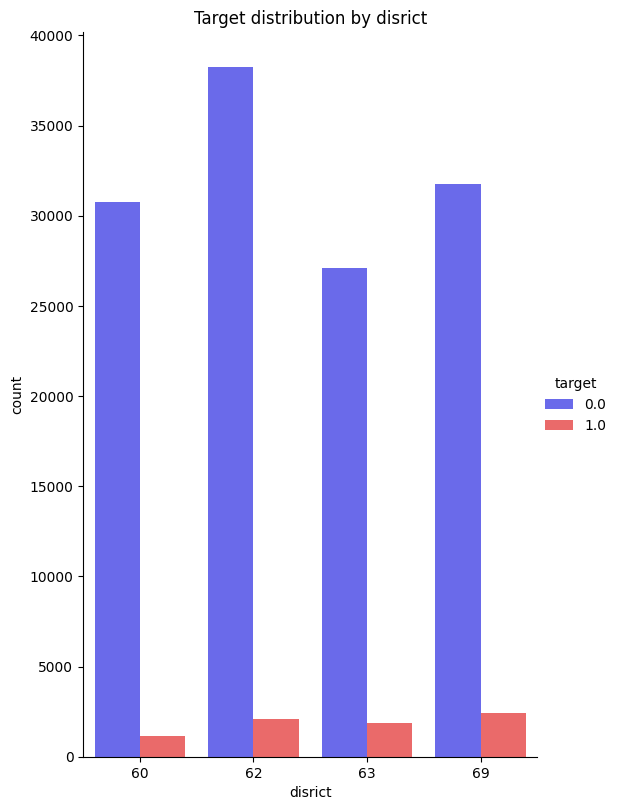

In [25]:
print(client_train['disrict'].value_counts())
plt.figure(figsize=(11,5))
sns.catplot(x='disrict', hue='target', data=client_train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Target distribution by disrict')
plt.xlabel('disrict')
plt.ylabel('count')
plt.show()

region
101    33770
104    12865
311    12406
107     9998
301     9544
103     8964
306     6044
303     5982
310     4851
312     4379
302     4311
304     3828
309     3669
307     3376
305     2716
313     2076
371     2065
105     1645
308      841
106      706
372      644
379      583
399      175
206       53
199        2
Name: count, dtype: int64


<Figure size 1100x500 with 0 Axes>

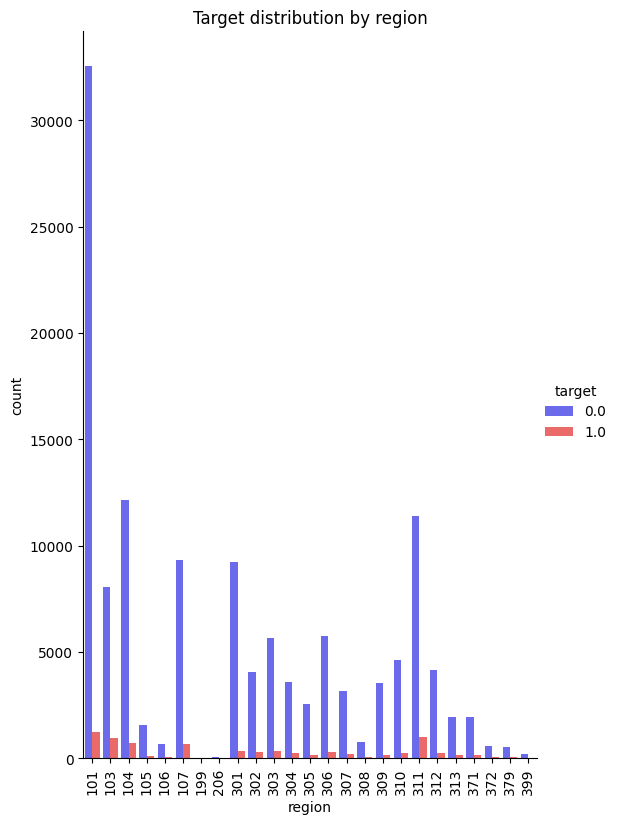

In [26]:
print(client_train['region'].value_counts())
plt.figure(figsize=(11,5))
sns.catplot(x='region', hue='target', data=client_train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Target distribution by region')
plt.xlabel('region')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [87]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target,region_group,coop_time
0,60,train_Client_0,11,101,1994-12-31,0.0,200,288
1,69,train_Client_1,11,107,2002-05-29,0.0,200,199
2,62,train_Client_10,11,301,1986-03-13,0.0,300,393
3,69,train_Client_100,11,105,1996-07-11,0.0,200,269
4,62,train_Client_1000,11,303,2014-10-14,0.0,300,50


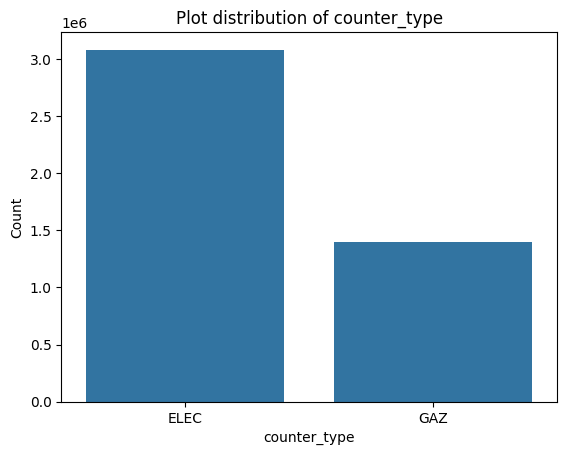

In [28]:
# Explore Target distribution
sns.countplot(x='counter_type', data=invoice_train)
plt.title('Plot distribution of counter_type')
plt.xlabel('counter_type')
plt.ylabel('Count')
plt.show()

In [84]:
for df in [invoice_train, invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    df['day'] = df['invoice_date'].dt.day
    df['week'] = df['invoice_date'].dt.isocalendar().week
    df.drop(columns=['invoice_date'], inplace=True)


In [88]:
for df in [client_train, client_test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['year'] = df['creation_date'].dt.year
    df['month'] = df['creation_date'].dt.month
    df['day'] = df['creation_date'].dt.day
    df['week'] = df['creation_date'].dt.isocalendar().week
    df.drop(columns=['creation_date'], inplace=True)



In [93]:
le = LabelEncoder()
for df in [invoice_train, invoice_test]:
    df['counter_type'] = le.fit_transform(df['counter_type'])



In [116]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [117]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean', 'std','min','max']
    aggs['consommation_level_2'] = ['mean', 'std','min','max']
    aggs['consommation_level_3'] = ['mean', 'std','min','max']
    aggs['consommation_level_4'] = ['mean', 'std','min','max']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [118]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)
agg_test = aggregate_by_client_id(invoice_test)

In [119]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [120]:
train.head()

,disrict,client_id,client_catg,region,target,region_group,coop_time,year,month,day,...,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_std,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_std,consommation_level_4_min,consommation_level_4_max
0,0,train_Client_0,11,0,0.0,200,288,1994,12,31,...,0,186,0.000000,0.000000,0,0,0.000000,0.000000,0,0
1,3,train_Client_1,11,5,0.0,200,199,2002,5,29,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0
2,1,train_Client_10,11,8,0.0,300,393,1986,3,13,...,0,682,0.000000,0.000000,0,0,0.000000,0.000000,0,0
3,3,train_Client_100,11,3,0.0,200,269,1996,7,11,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0
4,1,train_Client_1000,11,10,0.0,300,50,2014,10,14,...,0,400,117.357143,289.433294,0,800,36.714286,105.421081,0,382


In [121]:
test.head()

,disrict,client_id,client_catg,region,region_group,coop_time,year,month,day,week,...,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_std,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_std,consommation_level_4_min,consommation_level_4_max
0,1,test_Client_0,11,13,300,199,2002,5,28,22,...,0,120,0.000000,0.000000,0,0,0.000000,0.000000,0,0
1,3,test_Client_1,11,1,200,112,2009,8,6,32,...,0,4053,182.318182,316.613838,0,1144,586.318182,2750.076040,0,12899
2,1,test_Client_10,11,16,300,176,2004,4,7,15,...,0,400,15.743243,101.690110,0,800,0.162162,1.394972,0,12
3,0,test_Client_100,11,0,200,314,1992,10,8,41,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0
4,1,test_Client_1000,11,7,300,497,1977,7,21,29,...,0,1362,33.679245,187.919149,0,1340,0.000000,0.000000,0,0


In [122]:
train.shape,test.shape

((135493, 28), (58069, 27))

In [123]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

 # Data Processing

 - Check for Correlation
 - Positive Correlation

In [124]:
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() > 0]

consommation_level_1_mean    0.005861
day                          0.006683
region_group                 0.008828
consommation_level_2_mean    0.009712
consommation_level_4_mean    0.015081
consommation_level_2_std     0.018502
consommation_level_2_max     0.020182
region                       0.024936
consommation_level_3_mean    0.031021
consommation_level_1_max     0.031022
consommation_level_1_std     0.032546
consommation_level_4_std     0.032567
consommation_level_4_max     0.043202
coop_time                    0.052246
client_catg                  0.054745
disrict                      0.057501
consommation_level_3_std     0.081967
consommation_level_3_max     0.098889
1transactions_count          0.127044
target                       1.000000
Name: target, dtype: float64

- Negative Correlation

In [125]:
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() < 0]

year                       -0.052094
consommation_level_1_min   -0.020456
consommation_level_2_min   -0.005783
month                      -0.001891
week                       -0.001416
consommation_level_4_min   -0.001275
consommation_level_3_min   -0.001050
Name: target, dtype: float64

# Visualize the Correlation

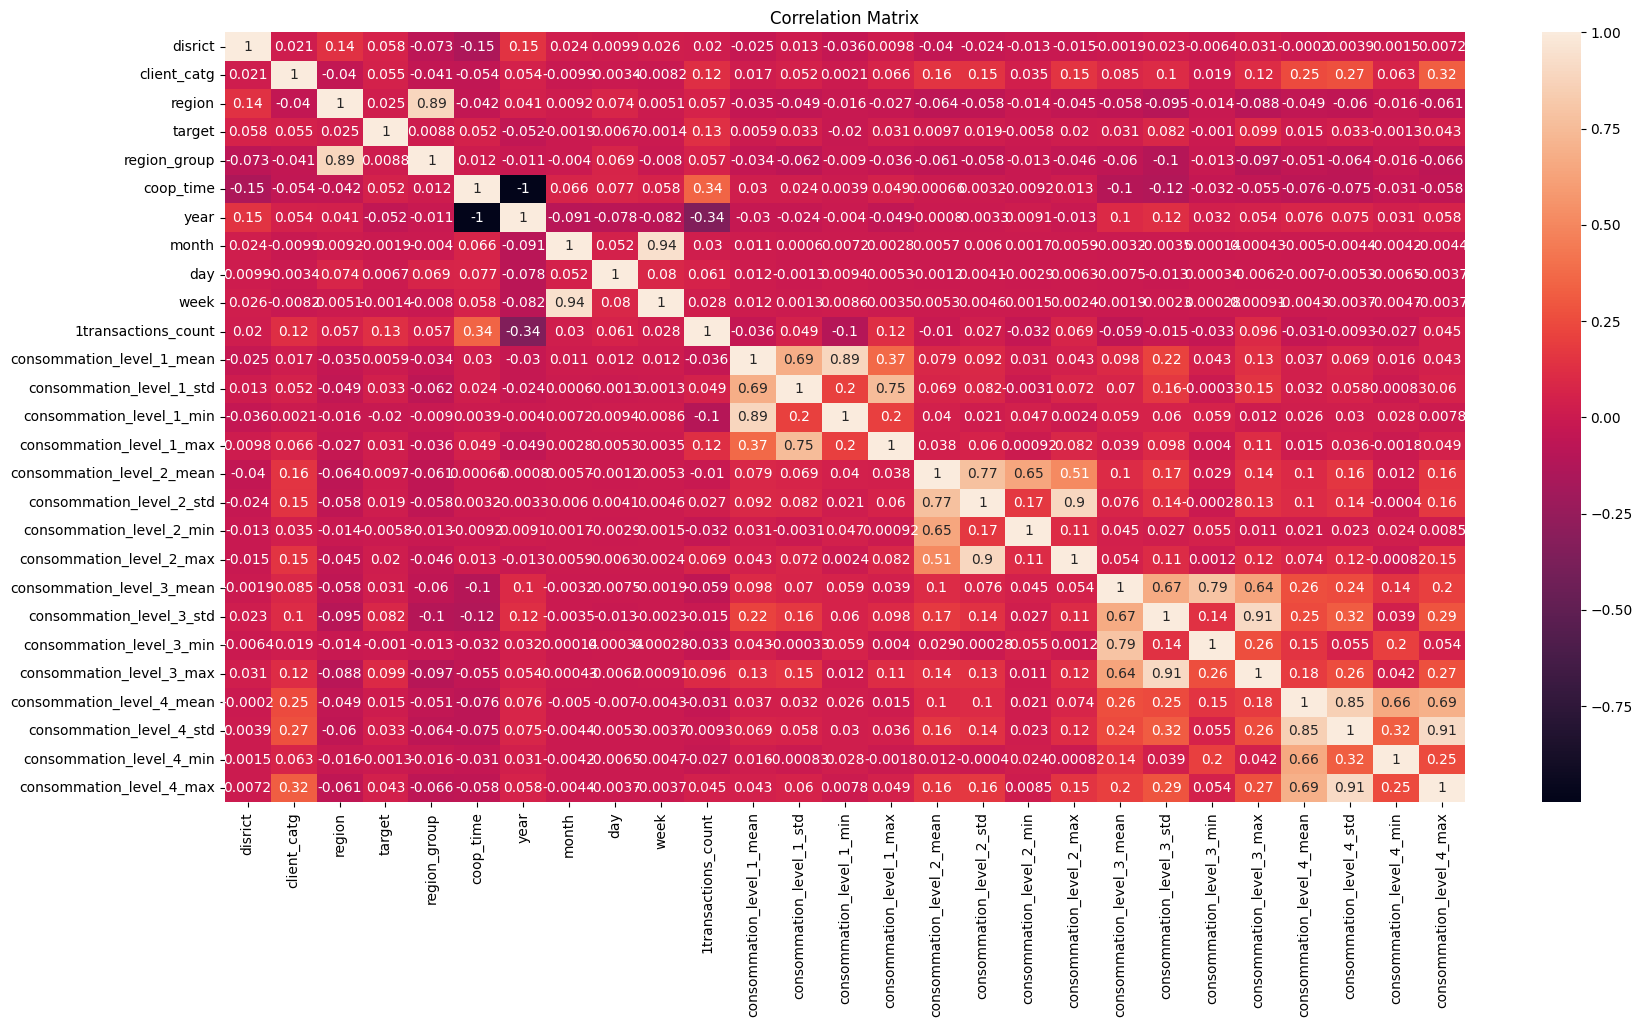

In [126]:
corr_matrix = train.corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [127]:
train.columns

Index(['disrict', 'client_catg', 'region', 'target', 'region_group',
       'coop_time', 'year', 'month', 'day', 'week', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_1_std',
       'consommation_level_1_min', 'consommation_level_1_max',
       'consommation_level_2_mean', 'consommation_level_2_std',
       'consommation_level_2_min', 'consommation_level_2_max',
       'consommation_level_3_mean', 'consommation_level_3_std',
       'consommation_level_3_min', 'consommation_level_3_max',
       'consommation_level_4_mean', 'consommation_level_4_std',
       'consommation_level_4_min', 'consommation_level_4_max'],
      dtype='object')

In [128]:

main_cols = ['disrict', 'client_catg', 'region', 'region_group',
       'coop_time', 'year', 'month', 'day', 'week', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_1_std',
       'consommation_level_1_min', 'consommation_level_1_max',
       'consommation_level_2_mean', 'consommation_level_2_std',
       'consommation_level_2_min', 'consommation_level_2_max',
       'consommation_level_3_mean', 'consommation_level_3_std',
       'consommation_level_3_min', 'consommation_level_3_max',
       'consommation_level_4_mean', 'consommation_level_4_std',
       'consommation_level_4_min', 'consommation_level_4_max']
X = train[main_cols]
y = train.target
test = test[main_cols]
model = CatBoostClassifier(random_state = 42)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500,
          verbose = 200)

Learning rate set to 0.101439
0:	learn: 0.5692166	test: 0.5693196	test1: 0.5692582	best: 0.5692582 (0)	total: 56.3ms	remaining: 56.2s
200:	learn: 0.1777473	test: 0.1778023	test1: 0.1885779	best: 0.1885779 (200)	total: 7.79s	remaining: 31s
400:	learn: 0.1677368	test: 0.1677902	test1: 0.1886193	best: 0.1882990 (271)	total: 17.7s	remaining: 26.4s
600:	learn: 0.1595911	test: 0.1596434	test1: 0.1890064	best: 0.1882990 (271)	total: 27.4s	remaining: 18.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1882990437
bestIteration = 271

Shrink model to first 272 iterations.


In [129]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df

get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
9,1transactions_count,24.262667
4,coop_time,13.188719
5,year,8.312882
10,consommation_level_1_mean,6.285087
12,consommation_level_1_min,6.238929
2,region,6.203487
11,consommation_level_1_std,5.229545
13,consommation_level_1_max,4.021309
0,disrict,3.483141
15,consommation_level_2_std,3.140092


In [130]:
# extract feature importances
feature_importances = model.feature_importances_
feature_names = train_features.columns

# Sort features and importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 20):')

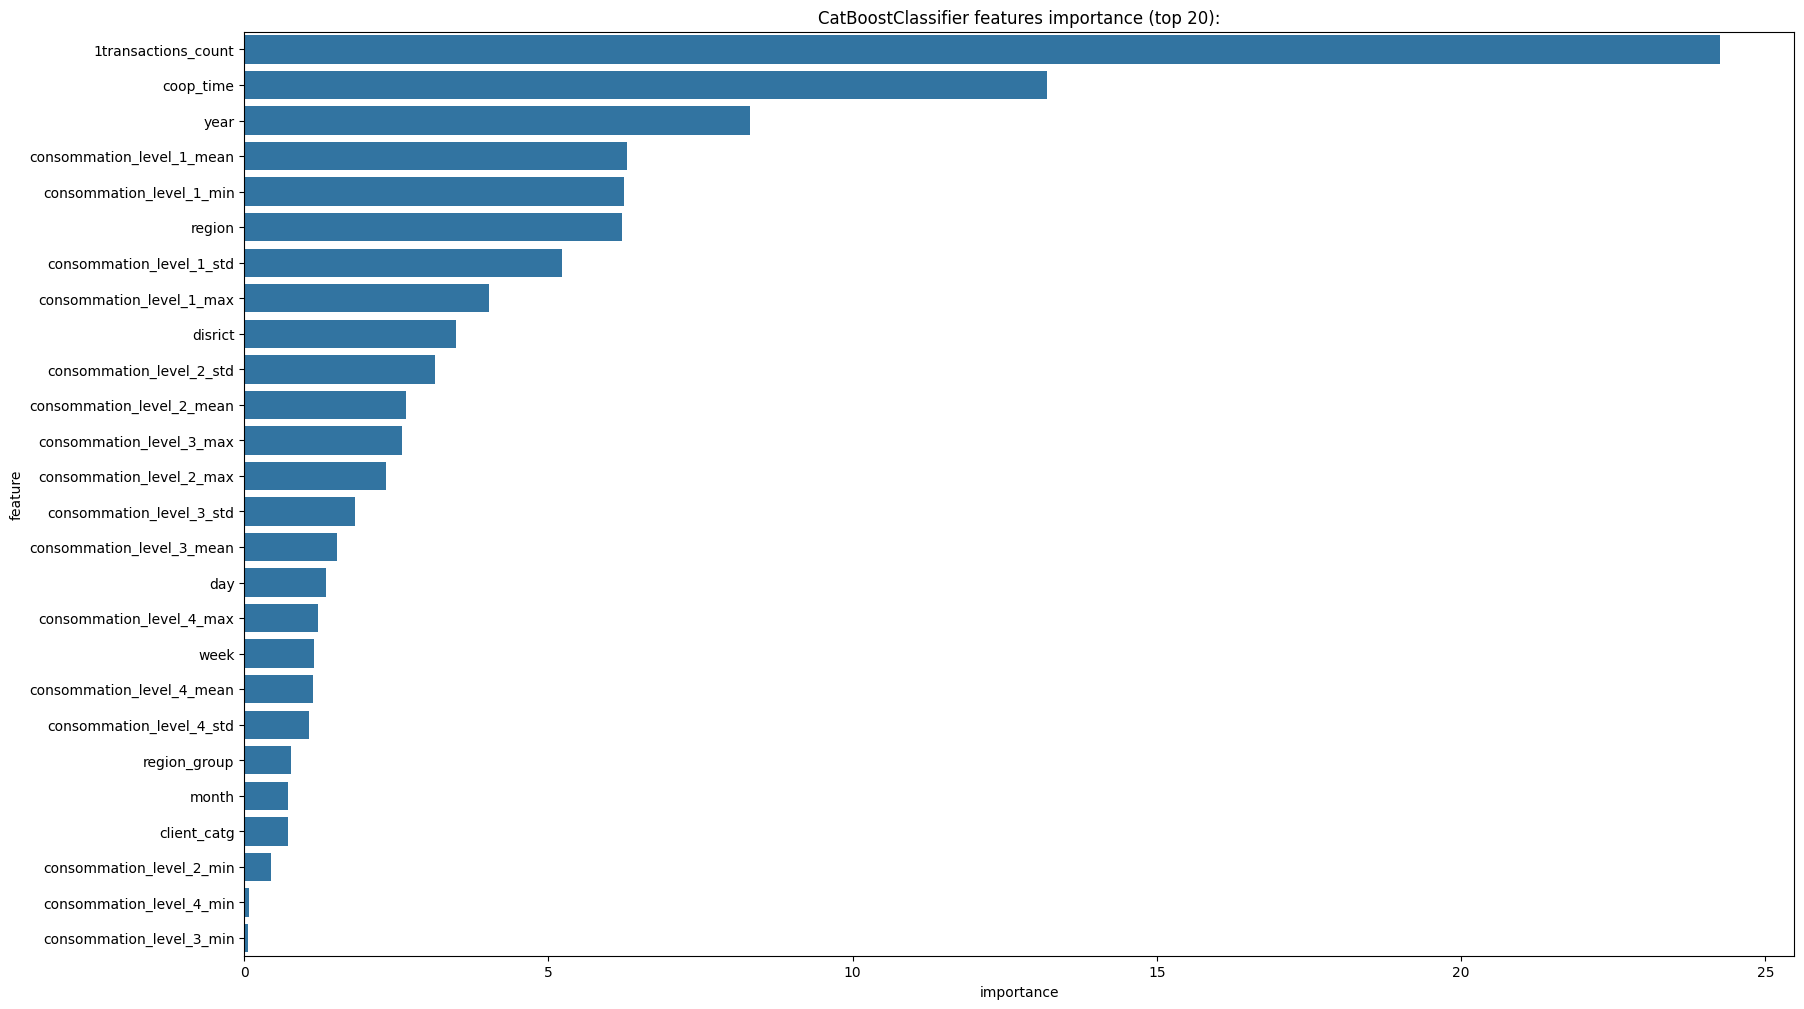

In [133]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 20):')

In [140]:
params = {
    'iterations': 10000,
    'random_state': 42,
    'bootstrap_type': 'Bernoulli',
    'max_depth': 7,
    'learning_rate': 0.008436034013684798,
    'l2_leaf_reg': 0.8908564261285311,
}

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=10, test_size=0.18, random_state=47)

fold_pred = []
oof_pred = []

i = 1
for train_index, test_index in split.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=250, verbose= 200)

    preds = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, preds)
    print(f"Fold {i} AUC: {auc_score}")
    oof_pred.append(auc_score)

    p2 = model.predict_proba(test)[:, 1]
    fold_pred.append(p2)
    i += 1

print(f"Mean AUC: {np.mean(oof_pred)}")

# Average the predictions from each fold for the test set
fold_pred_mean = np.mean(fold_pred, axis=0)

0:	learn: 0.6813174	test: 0.6813723	test1: 0.6813354	best: 0.6813354 (0)	total: 42ms	remaining: 6m 59s
200:	learn: 0.2028697	test: 0.2029511	test1: 0.2041353	best: 0.2041353 (200)	total: 9.15s	remaining: 7m 25s
400:	learn: 0.1894924	test: 0.1895570	test1: 0.1925330	best: 0.1925330 (400)	total: 18.2s	remaining: 7m 16s
600:	learn: 0.1862731	test: 0.1863329	test1: 0.1908137	best: 0.1908137 (600)	total: 28.5s	remaining: 7m 26s
800:	learn: 0.1841832	test: 0.1842414	test1: 0.1901144	best: 0.1901144 (800)	total: 36.9s	remaining: 7m 4s
1000:	learn: 0.1824524	test: 0.1825098	test1: 0.1897117	best: 0.1897092 (999)	total: 46.4s	remaining: 6m 57s
1200:	learn: 0.1808506	test: 0.1809075	test1: 0.1893611	best: 0.1893611 (1200)	total: 56.5s	remaining: 6m 54s
1400:	learn: 0.1792764	test: 0.1793329	test1: 0.1890488	best: 0.1890476 (1397)	total: 1m 4s	remaining: 6m 33s
1600:	learn: 0.1776214	test: 0.1776774	test1: 0.1888408	best: 0.1888408 (1600)	total: 1m 14s	remaining: 6m 29s
1800:	learn: 0.1760958	tes

In [143]:
submission = pd.DataFrame({
    "client_id": ss["client_id"],
    "target": fold_pred_mean
})
submission.to_csv('submission.csv', index=False)